In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10/',
                            download=True, train=True, transform=transform)
training_loader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True)

testset = datasets.CIFAR10('~/.pytorch/CIFAR10/',
                           download=True, train=False, transform=transform)
validation_loader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=True)
# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('Validation set has {} instances'.format(len(testset)))


Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


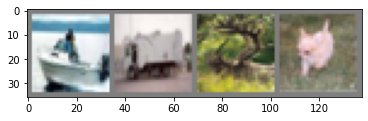

ship 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(1)))


In [3]:
def softmax(inputs):
    return (inputs.exp() / inputs.exp().sum(-1)).log()


In [4]:
def softmax_T(inputs, T):

    exp_values = inputs.exp() / T
    probabilities = exp_values / torch.sum(exp_values, 1, True)
    return probabilities.log()


In [5]:
def my_cross_entropy(x, y, T):
    log_prob = -1.0 * softmax_T(x, T)
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()


In [7]:
def train_one_epoch(epoch_index, tb_writer, T, lr):
    running_loss = 0.
    last_loss = 0.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = my_cross_entropy(outputs, labels, T)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


In [8]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
EPOCHS = 4
T =  1
lr = 0.002
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, T, lr)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = my_cross_entropy(voutputs, vlabels, T)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


EPOCH 1:
  batch 1000 loss: 2.253079162836075
  batch 2000 loss: 1.9336237549185753
  batch 3000 loss: 1.76477416908741
  batch 4000 loss: 1.697356950044632
  batch 5000 loss: 1.6150408153831959
  batch 6000 loss: 1.5800360586047173
  batch 7000 loss: 1.5386719086766243
  batch 8000 loss: 1.5123566644191742
  batch 9000 loss: 1.48219885507226
  batch 10000 loss: 1.449535464823246
  batch 11000 loss: 1.4364993061125277
  batch 12000 loss: 1.4312447030842304
LOSS train 1.4312447030842304 valid 1.4705841541290283
EPOCH 2:
  batch 1000 loss: 1.3560163553208113
  batch 2000 loss: 1.344602300003171
  batch 3000 loss: 1.3826449418663977
  batch 4000 loss: 1.3484684590026736
  batch 5000 loss: 1.3746327787041663
  batch 6000 loss: 1.3146665181294084
  batch 7000 loss: 1.3160776864737271
  batch 8000 loss: 1.3176356462165713
  batch 9000 loss: 1.3215975956767798
  batch 10000 loss: 1.309199625082314
  batch 11000 loss: 1.3081920791640878
  batch 12000 loss: 1.2725994857102632
LOSS train 1.27259

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 56 %


In [10]:
del(labels)


In [11]:
embeddings = []
targets = []
with torch.no_grad():
    for i, data in enumerate(validation_loader):
        images, labels = data[0].to(device), data[1].to(device)
        embeddings.append(model(images).cpu().detach().numpy())
        targets.append(labels.cpu().detach().numpy())


In [12]:
flattened = [val for sublist in embeddings for val in sublist]


In [13]:
flattened_target = [val for sublist in targets for val in sublist]


In [14]:
len(flattened_target)


10000

In [15]:
avg_vloss


tensor(1.2450, device='cuda:0', grad_fn=<DivBackward0>)

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)

tsne_proj = tsne.fit_transform(flattened)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.862s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.004001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.072342
[t-SNE] KL divergence after 1000 iterations: 1.792372


In [17]:
import pandas as pd
df = pd.DataFrame()
df['x'] = tsne_proj[:, 0]
df['y'] = tsne_proj[:, 1]
df['label'] = flattened_target


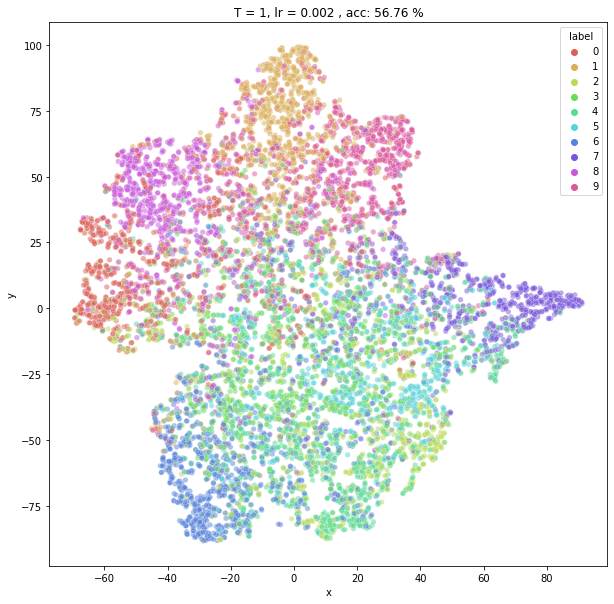

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

plt.figure(figsize=[10, 10])
sns.scatterplot(data=df, x="x", y="y", alpha=0.5, hue='label', palette=sns.color_palette(
    "hls", 10), s=30).set(title=f"T = {T}, lr = {lr} , acc: {100 * correct / total} %")
plt.savefig(f'plots/{timestamp}.png')
